In [196]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

In [197]:
data_dir = '/kaggle/input/fruit-recognition/train/train'
dataset = datasets.ImageFolder(root=data_dir)

In [198]:
dataset.classes

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']

In [199]:
len(dataset)

16854

In [200]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [201]:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)), 
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [202]:
means = []
stds = []
for img, _ in val_data:
    means.append(torch.mean(img, [1, 2]).tolist())
    stds.append(torch.std(img, [1, 2]).tolist())

mean = torch.mean(torch.tensor(means), [0])
std = torch.mean(torch.tensor(stds), [0])

mean, std

(tensor([0.6856, 0.4277, 0.3506]), tensor([1.2051, 1.4657, 1.6443]))

In [203]:
len(train_data), len(val_data)

(13484, 3370)

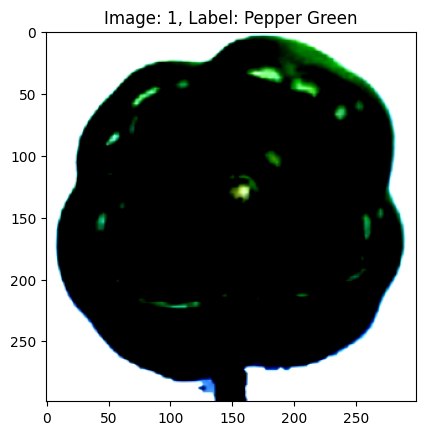

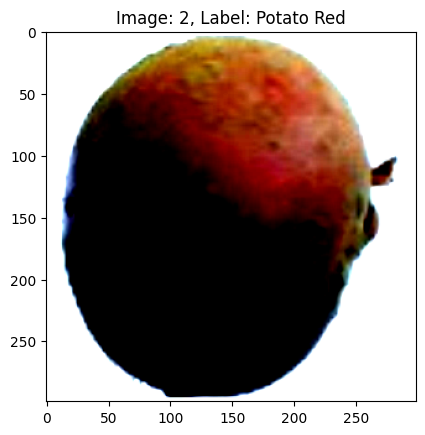

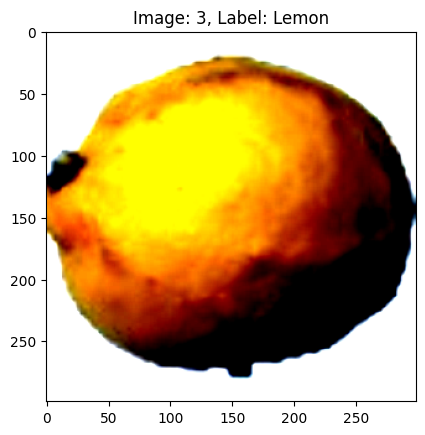

In [204]:
import matplotlib.pyplot as plt

for i in range(3):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = dataset.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

In [205]:
batch_size = 256

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [206]:
from torchvision import models

inception = models.inception_v3(pretrained=True)
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [207]:
from torch import nn
import torch.nn.functional as F
import numpy as np


class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        inception = models.inception_v3(pretrained=True)
        
        # від'єднання градієнтів
        for param in inception.parameters():
            param.requires_grad = False
        
        # кількість нейронів на виході
        in_features = inception.fc.in_features
        
        # деактивація останнього шару
        inception.fc = nn.Identity()
        
        # створення потрібних шарів
        self.feature_extractor = inception
        
        # Лінійний шар для зменшення розміру
        self.linear1 = nn.Linear(in_features, in_features // 16)
        self.relu = nn.ReLU()
        
        # Фінальний лінійний шар для отримання кількості класів
        self.linear2 = nn.Linear(in_features // 16, num_classes)
        
    def forward(self, x):
    # Получение признаков из Inception
        features = self.feature_extractor(x)
    
    # Если InceptionOutputs возвращает несколько выходов, выбираем основной выход
        if isinstance(features, tuple):
            features = features[0]  # Основной выход

    # Применение линейного слоя
        out = self.relu(self.linear1(features))
        out = self.linear2(out)
        return out


    def predict(self, X, device='cpu'):
    # Преобразуем данные в тензор и отправляем на нужное устройство
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
        # Получаем предсказания от модели
            y_pred = self.forward(X)
        
        # Применяем softmax к выходам модели для получения вероятностей
            y_pred = F.softmax(y_pred, dim=-1)

    # Возвращаем вероятности как numpy массив
        return y_pred.cpu().numpy()


model = TransferLearningClassifier(len(dataset.classes)).to(device)

In [208]:
!pip install -q torchsummary

In [209]:
from torchsummary import summary

summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [210]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [211]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass
    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}
        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)
        
        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)

                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)
            
        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [212]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLearningClassifier, opt=Adam(lr=0.001000), epochs=10, device=cuda

Epoch    1  135sec	loss:       1.38	val_loss:      0.197	accuracy_score:      0.793	val_accuracy_score:       0.99	
Epoch    2  127sec	loss:      0.132	val_loss:     0.0524	accuracy_score:      0.992	val_accuracy_score:      0.998	
Epoch    3  129sec	loss:     0.0577	val_loss:     0.0272	accuracy_score:      0.996	val_accuracy_score:      0.999	
Epoch    4  129sec	loss:      0.035	val_loss:     0.0166	accuracy_score:      0.998	val_accuracy_score:          1	
Epoch    5  129sec	loss:     0.0255	val_loss:     0.0124	accuracy_score:      0.998	val_accuracy_score:      0.999	
Epoch    6  129sec	loss:     0.0196	val_loss:    0.00861	accuracy_score:      0.999	val_accuracy_score:          1	
Epoch    7  128sec	loss:     0.0148	val_loss:     0.0071	accuracy_score:      0.999	val_accuracy_score:          1	
Epoch    8  128sec	loss:     0.0127	val_loss:    0.00532	accuracy_score:      0.999	val_acc

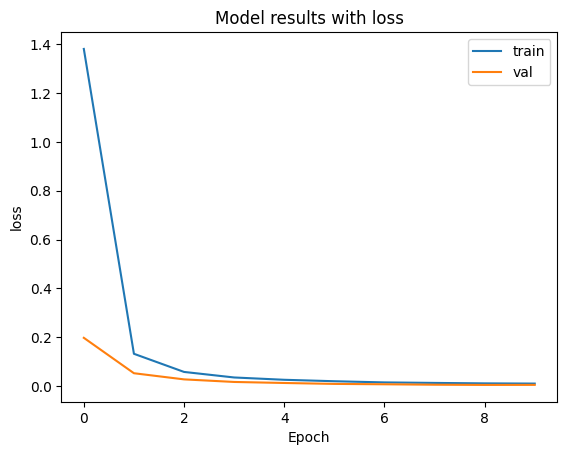

In [213]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

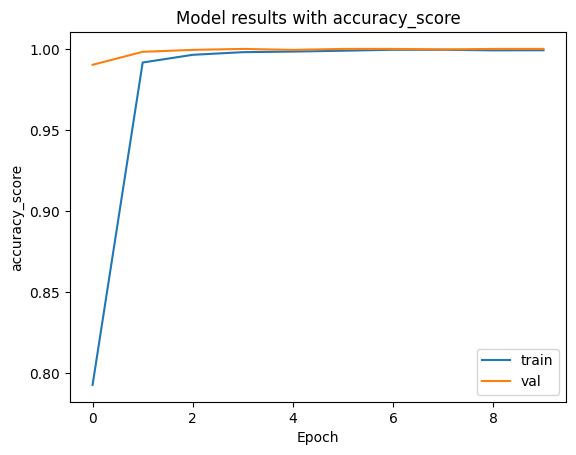

In [214]:
plot_metric(history, 'accuracy_score')

[]

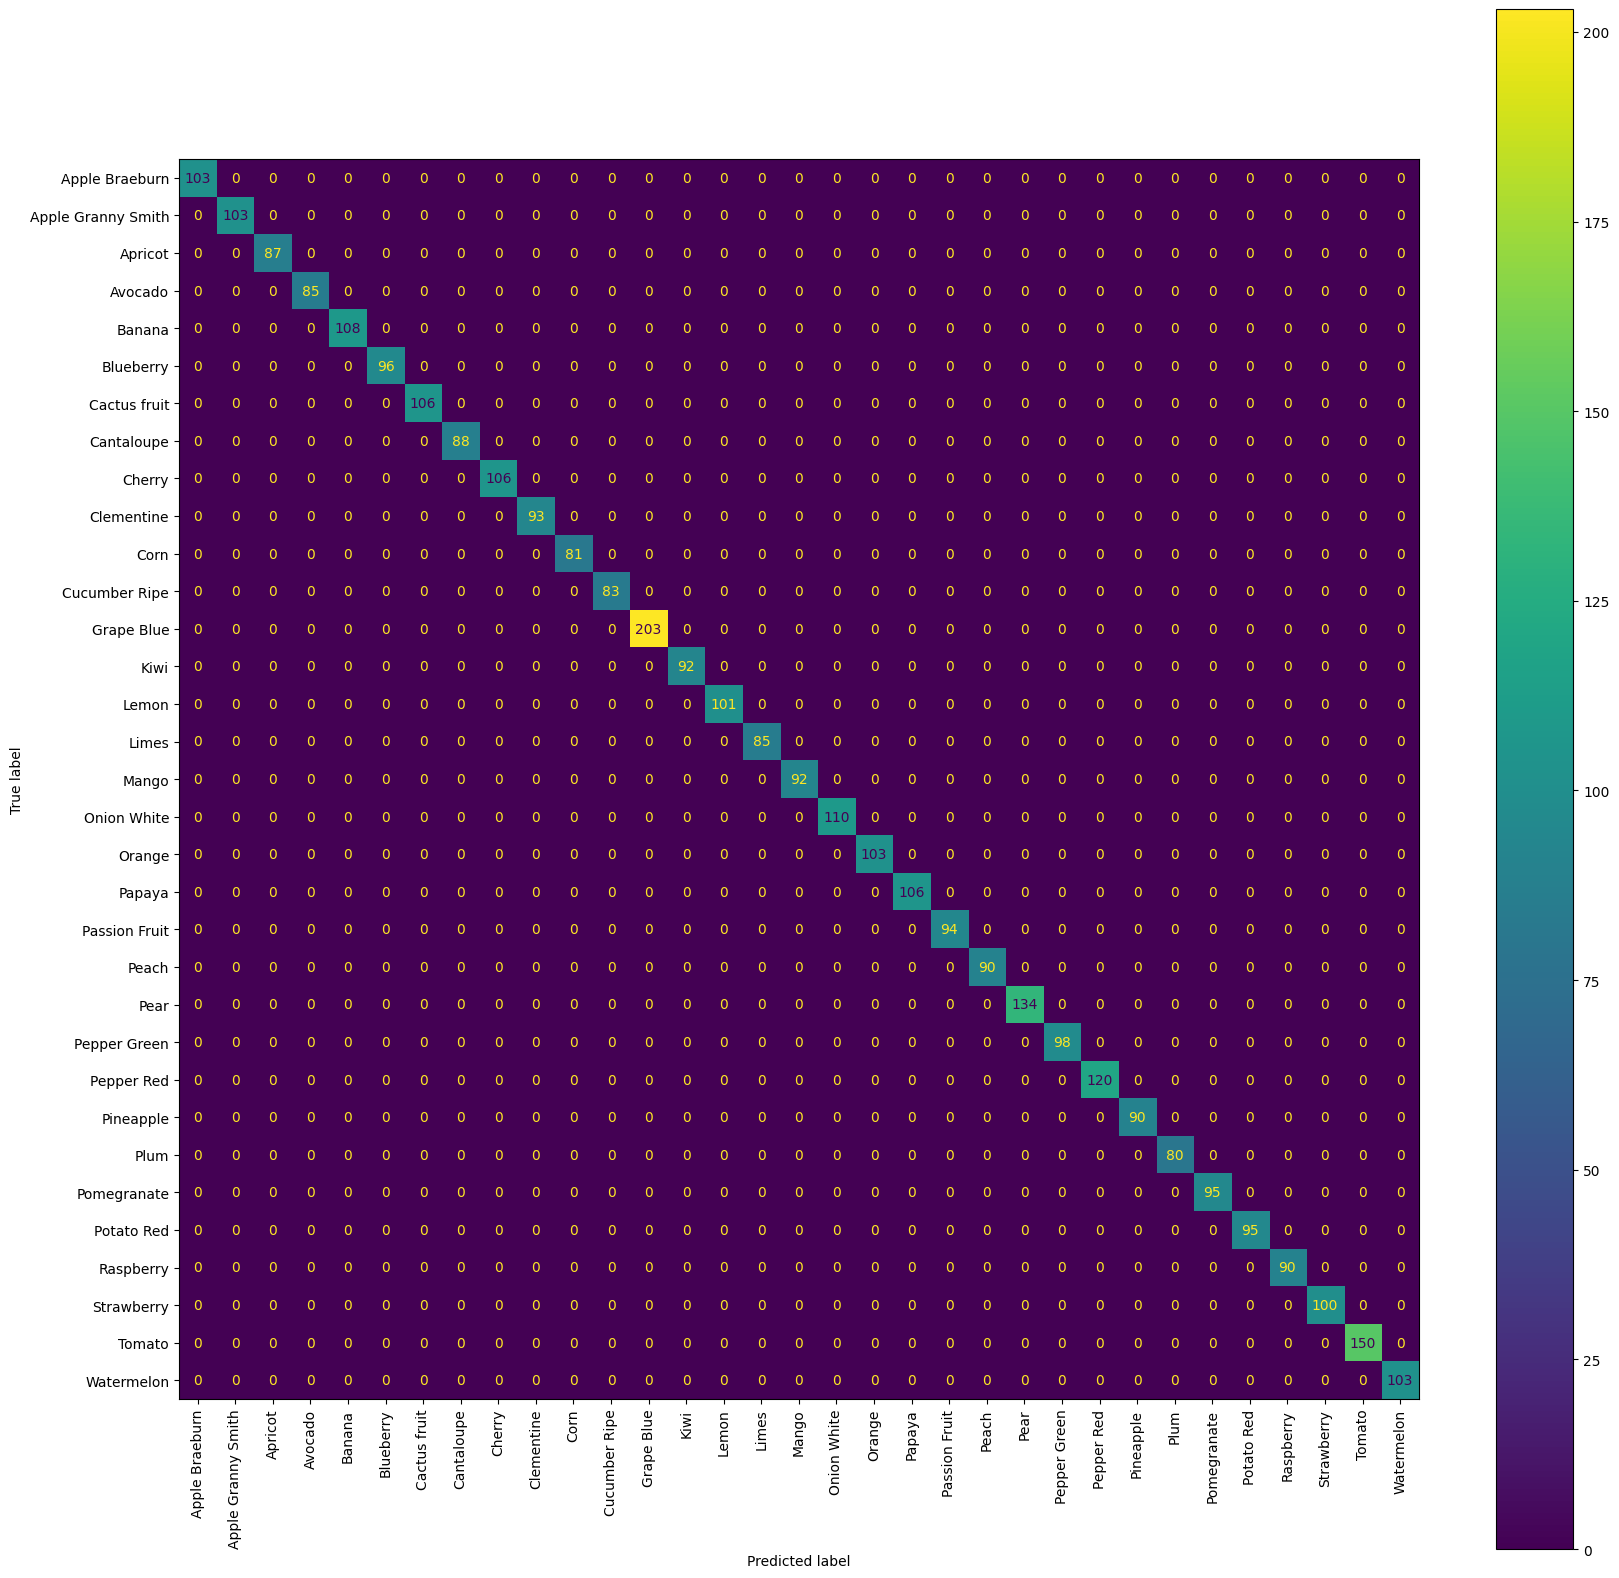

In [215]:
from sklearn.metrics import ConfusionMatrixDisplay
model = model.to(device)
model.eval()
 
y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y_pred_ = model(X)
        y_pred_ = y_pred_.argmax(-1).cpu()
        y_pred.extend(y_pred_)
        y_test.extend(y)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dataset.classes)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(20, 20)
plt.plot()

In [216]:
torch.save(model, 'model.pt')

In [217]:
model = torch.load('model.pt')

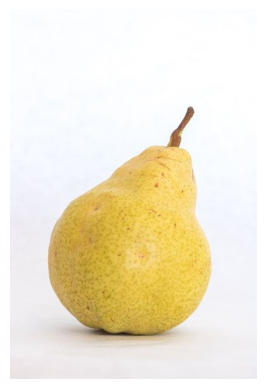

Pear


In [229]:
from PIL import Image

def load_and_predict(image_path, model, transform, device='cpu'):
    image =  Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = transform(image).unsqueeze(0)

    model = model.to(device)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()

    class_name = dataset.classes[prediction]
    
    return class_name

image_path = '/kaggle/input/test-dataset/pear.jpg'
predicted_class = load_and_predict(image_path, model, test_transform, device=device)
print(predicted_class)